# ASL Recognition: End-to-End Workflow

This notebook consolidates the entire workflow for preprocessing, model training, and evaluation for American Sign Language (ASL) recognition.


In [15]:
# Import Required Libraries
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pickle
from tqdm.notebook import tqdm  # Use notebook-friendly version of tqdm

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Preprocessing: Load and Normalize Keypoints

We will load the preprocessed keypoints from the JSON files and normalize them.


In [16]:
# Configuration
DATA_DIR = Path(r'f:\Uni_Stuff\6th_Sem\DL\Proj\video-asl-recognition\pose_estimation\data\keypoints')
NUM_CLASSES_TO_USE = None  # Set to an integer to limit the number of classes

# Load and normalize keypoints
# Now also return sequence lengths for masking

def load_keypoints(data_dir, num_classes_to_use=5):
    data = []
    labels = []
    lengths = []
    skipped_files = 0
    processed_files = 0
    print(f"Loading keypoints from {data_dir}")
    # Gather all class folders and sort them alphabetically
    all_class_dirs = sorted([d for d in data_dir.iterdir() if d.is_dir()])
    if num_classes_to_use is not None:
        all_class_dirs = all_class_dirs[:num_classes_to_use]

    # Generate label2idx mapping dynamically
    label2idx = {}
    valid_class_dirs = []
    for class_dir in all_class_dirs:
        json_files = list(class_dir.glob('*.json'))
        if len(json_files) >= 2:
            valid_class_dirs.append(class_dir)
            label2idx[class_dir.name] = len(label2idx)
        else:
            print(f"Skipping class {class_dir.name}: Less than 2 instances available.")

    print(f"Using the following classes: {list(label2idx.keys())}")

    # Gather all JSON files from the selected class directories
    all_json_files = []
    class_instance_count = {class_name: 0 for class_name in label2idx.keys()}
    for class_dir in valid_class_dirs:
        json_files = list(class_dir.glob('*.json'))
        class_instance_count[class_dir.name] = len(json_files)
        all_json_files.extend(json_files)

    # Filter out classes with fewer than 2 instances
    valid_classes = [class_name for class_name, count in class_instance_count.items() if count >= 2]
    label2idx = {class_name: idx for idx, class_name in enumerate(valid_classes)}
    print(f"Final valid classes: {valid_classes}")

    for json_file in tqdm(all_json_files, desc="Loading keypoint files"):
        try:
            with open(json_file, 'r') as f:
                content = json.load(f)
            keypoints = content.get('keypoints', None)
            label = content.get('label', None)
            if label not in label2idx:
                print(f"Skipping {json_file}: Label '{label}' not in label2idx mapping.")
                skipped_files += 1
                continue
            if not keypoints:
                print(f"Skipping {json_file}: Keypoints are empty or missing.")
                skipped_files += 1
                continue
            processed_frames = []
            for frame in keypoints:
                left_hand_features = np.zeros(63, dtype=np.float32)
                right_hand_features = np.zeros(63, dtype=np.float32)
                pose_features = np.zeros(99, dtype=np.float32)
                if 'hands' in frame and frame['hands']:
                    for i, hand in enumerate(frame['hands']):
                        if i < 2:
                            hand_features = []
                            for point in hand:
                                if isinstance(point, list) and len(point) == 3:
                                    hand_features.extend(point)
                            if i == 0 and len(hand_features) <= 63:
                                left_hand_features[:len(hand_features)] = hand_features
                            elif i == 1 and len(hand_features) <= 63:
                                right_hand_features[:len(hand_features)] = hand_features
                if 'pose' in frame and frame['pose']:
                    pose_data = []
                    for point in frame['pose']:
                        if isinstance(point, list) and len(point) == 3:
                            pose_data.extend(point)
                    if len(pose_data) <= 99:
                        pose_features[:len(pose_data)] = pose_data
                frame_features = np.concatenate([left_hand_features, right_hand_features, pose_features])
                processed_frames.append(frame_features)
            if processed_frames:
                processed_data = np.array(processed_frames, dtype=np.float32)
                if processed_data.shape[0] > 0 and processed_data.shape[1] > 0:
                    data.append(processed_data)
                    labels.append(label2idx[label])
                    lengths.append(processed_data.shape[0])
                    processed_files += 1
                else:
                    print(f"Skipping {json_file}: Processed frames are invalid.")
                    skipped_files += 1
            else:
                print(f"Skipping {json_file}: No valid frames were processed.")
                skipped_files += 1
        except Exception as e:
            print(f"Skipping {json_file}: Exception occurred - {e}")
            skipped_files += 1
    print(f"Processed {processed_files} files successfully, skipped {skipped_files} files")
    if not data:
        print("Warning: No valid data was loaded!")
        return np.array([]), np.array([]), np.array([]), label2idx
    max_seq_len = max(sample.shape[0] for sample in data)
    feature_dim = data[0].shape[1]
    padded_data = []
    for sample in data:
        if sample.shape[0] < max_seq_len:
            padding = np.zeros((max_seq_len - sample.shape[0], feature_dim), dtype=np.float32)
            padded_sample = np.vstack((sample, padding))
        else:
            padded_sample = sample[:max_seq_len]
        padded_data.append(padded_sample)
    return np.array(padded_data), np.array(labels), np.array(lengths), label2idx

data, labels, lengths, label2idx = load_keypoints(DATA_DIR, NUM_CLASSES_TO_USE)

Loading keypoints from f:\Uni_Stuff\6th_Sem\DL\Proj\video-asl-recognition\pose_estimation\data\keypoints
Using the following classes: ['about', 'accident', 'africa', 'again', 'all', 'always', 'animal', 'apple', 'approve', 'argue', 'arrive', 'baby', 'back', 'backpack', 'bad', 'bake', 'balance', 'ball', 'banana', 'bar', 'basketball', 'bath', 'bathroom', 'beard', 'because', 'bed', 'before', 'behind', 'bird', 'birthday', 'black', 'blanket', 'blue', 'book', 'bowling', 'boy', 'bring', 'brother', 'brown', 'business', 'but', 'buy', 'call', 'can', 'candy', 'careful', 'cat', 'catch', 'center', 'cereal', 'chair', 'champion', 'change', 'chat', 'cheat', 'check', 'cheese', 'children', 'christmas', 'city', 'class', 'clock', 'close', 'clothes', 'coffee', 'cold', 'college', 'color', 'computer', 'convince', 'cook', 'cool', 'copy', 'corn', 'cough', 'country', 'cousin', 'cow', 'crash', 'crazy', 'cry', 'cute', 'dance', 'dark', 'daughter', 'day', 'deaf', 'decide', 'delay', 'delicious', 'different', 'disappe

Loading keypoint files:   0%|          | 0/3202 [00:00<?, ?it/s]

Processed 3202 files successfully, skipped 0 files


In [17]:
print("First 5 labels:")
print(labels[:5])
print("First 5 lengths:")
print(lengths[:5])


# After data, labels, lengths = load_keypoints(DATA_DIR)
print("Raw data statistics:")
if data.size > 0:
    # Print shapes of the first few samples
    print("Number of samples:", len(data))
    print("Shape of sample 0:", data[0].shape)
    # Compute min, max and mean for the first sample (raw frames)
    sample0 = data[0]
    print("Sample 0 - min:", np.min(sample0), "max:", np.max(sample0), "mean:", np.mean(sample0))
    # Print stddev for all raw data
    print("Raw data stddev:", np.std(data))
else:
    print("No data loaded.")

print("Label distribution:")
unique, counts = np.unique(labels, return_counts=True)
for l, count in zip(unique, counts):
    print(f"Label: {l}, Count: {count}")

print("Sequence lengths statistics:")
if lengths.size > 0:
    print("Min length:", np.min(lengths), "Max length:", np.max(lengths), "Mean length:", np.mean(lengths))
else:
    print("No sequence lengths available.")

# Specify the number of classes to use (set to None to use all classes)
num_classes_to_use = None
data, labels, lengths, label2idx = load_keypoints(DATA_DIR, num_classes_to_use)

First 5 labels:
[0 0 0 0 0]
First 5 lengths:
[16 16 16 16 16]
Raw data statistics:
Number of samples: 3202
Shape of sample 0: (16, 225)
Sample 0 - min: -2.6472163 max: 2.4947815 mean: 0.2292768
Raw data stddev: 0.6613013
Label distribution:
Label: 0, Count: 8
Label: 1, Count: 13
Label: 2, Count: 13
Label: 3, Count: 10
Label: 4, Count: 13
Label: 5, Count: 9
Label: 6, Count: 10
Label: 7, Count: 13
Label: 8, Count: 11
Label: 9, Count: 10
Label: 10, Count: 10
Label: 11, Count: 10
Label: 12, Count: 7
Label: 13, Count: 11
Label: 14, Count: 11
Label: 15, Count: 8
Label: 16, Count: 11
Label: 17, Count: 11
Label: 18, Count: 10
Label: 19, Count: 10
Label: 20, Count: 12
Label: 21, Count: 10
Label: 22, Count: 10
Label: 23, Count: 10
Label: 24, Count: 7
Label: 25, Count: 13
Label: 26, Count: 17
Label: 27, Count: 9
Label: 28, Count: 12
Label: 29, Count: 9
Label: 30, Count: 13
Label: 31, Count: 8
Label: 32, Count: 12
Label: 33, Count: 10
Label: 34, Count: 13
Label: 35, Count: 10
Label: 36, Count: 10


Loading keypoint files:   0%|          | 0/3202 [00:00<?, ?it/s]

Processed 3202 files successfully, skipped 0 files


In [18]:
# Feature normalization (global z-score normalization)
def normalize_features(data):
    # data: (num_samples, seq_len, num_features)
    mean = data.mean()
    std = data.std()
    normalized = (data - mean) / std
    return normalized, mean, std

# Apply global z-score normalization
data, mean, std = normalize_features(data)
print(f"Data shape after normalization: {data.shape}")

def create_mask(lengths, max_len):
    # lengths: (num_samples,)
    # returns mask: (num_samples, max_len) with 1 for real, 0 for pad
    mask = np.zeros((len(lengths), max_len), dtype=np.float32)
    for i, l in enumerate(lengths):
        mask[i, :l] = 1.0
    return mask

mask = create_mask(lengths, data.shape[1])

Data shape after normalization: (3202, 16, 225)


In [19]:
# After data, feat_center, feat_scale = normalize_features(data)
print("Normalized data statistics:")
if data.size > 0:
    print("Data shape:", data.shape)
    print("Min value:", np.min(data), "Max value:", np.max(data), "Median value:", np.median(data), "Mean value:", np.mean(data), "Std Dev:", np.std(data))
else:
    print("No data available after normalization.")

Normalized data statistics:
Data shape: (3202, 16, 225)
Min value: -6.65441 Max value: 4.175602 Median value: -0.23095042 Mean value: -7.791997e-08 Std Dev: 1.0


# Dataset Preparation: Train-Test Split

Split the dataset into training, validation, and test sets.


In [20]:
# Import train_test_split if not already imported
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import WeightedRandomSampler

# Create a mapping from string labels to numeric indices
label_to_index = {label: idx for idx, label in enumerate(np.unique(labels))}
index_to_label = {idx: label for label, idx in label_to_index.items()}
print(f"Label to index mapping: {label_to_index}")

# Convert string labels to numeric indices
numeric_labels = np.array([label_to_index[label] for label in labels])
print(f"Converted labels to numeric indices.")

# Split the dataset
X_train, X_temp, y_train, y_temp, mask_train, mask_temp = train_test_split(data, numeric_labels, mask, test_size=0.3, stratify=numeric_labels, random_state=42)
X_val, X_test, y_val, y_test, mask_val, mask_test = train_test_split(X_temp, y_temp, mask_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

# Compute class weights for balancing
class_weights = compute_class_weight('balanced', classes=np.unique(numeric_labels), y=numeric_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(f"Class weights: {class_weights}")
 
# Update DataLoader to use weighted sampling
# NOTE: train_dataset is not defined yet here, so just define the sampler and sample_weights for later use
sample_weights = class_weights[numeric_labels]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
# Do not create train_loader here; it will be created after train_dataset is defined

Label to index mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 57, 58: 58, 59: 59, 60: 60, 61: 61, 62: 62, 63: 63, 64: 64, 65: 65, 66: 66, 67: 67, 68: 68, 69: 69, 70: 70, 71: 71, 72: 72, 73: 73, 74: 74, 75: 75, 76: 76, 77: 77, 78: 78, 79: 79, 80: 80, 81: 81, 82: 82, 83: 83, 84: 84, 85: 85, 86: 86, 87: 87, 88: 88, 89: 89, 90: 90, 91: 91, 92: 92, 93: 93, 94: 94, 95: 95, 96: 96, 97: 97, 98: 98, 99: 99, 100: 100, 101: 101, 102: 102, 103: 103, 104: 104, 105: 105, 106: 106, 107: 107, 108: 108, 109: 109, 110: 110, 111: 111, 112: 112, 113: 113, 114: 114, 115: 115, 116: 116, 117: 117, 118: 118, 119: 

In [29]:
# Define the dataset class
class ASLDataset(Dataset):
    def __init__(self, data, labels, lengths):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.lengths = torch.tensor(lengths, dtype=torch.long)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx], self.lengths[idx]

# Create the datasets
train_dataset = ASLDataset(X_train, y_train, mask_train.sum(axis=1).astype(int))
val_dataset = ASLDataset(X_val, y_val, mask_val.sum(axis=1).astype(int))

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model Definition: BiLSTM for Temporal Data

Define a BiLSTM model for ASL recognition.


In [41]:
import torch
import torch.nn as nn
import numpy as np

# Print information about the data shape
print(f"Data shape: {data.shape}")
if len(data) > 0:
    print(f"Each sample has {data[0].shape[0]} frames with {data[0].shape[1]} features per frame")

# Replace RNNModel with BiLSTM
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout_rate=0.3):
        super(BiLSTM, self).__init__()
        self.lstm = nn.GRU(
            input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate if num_layers > 1 else 0
        )
        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x, lengths):
        # Pack the padded sequence
        packed_x = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.lstm(packed_x)
        # Unpack the sequence
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
        # Get the last valid output for each sequence
        idx = (lengths - 1).view(-1, 1).expand(-1, out.size(2)).unsqueeze(1)
        out = out.gather(1, idx).squeeze(1)
        out = self.layer_norm(out)
        out = self.dropout(out)
        out = self.fc(out)
        return out

# Get the input size from the processed data
input_size = data[0].shape[1] if len(data) > 0 else 0
hidden_size = 128
output_size = len(np.unique(labels))
print(f"Input size for the model: {input_size}")
print(f"Number of unique labels (classes): {output_size}")

model = BiLSTM(input_size, hidden_size, output_size)
print(model)
model = model.to(device)

Data shape: (3202, 16, 225)
Each sample has 16 frames with 225 features per frame
Input size for the model: 225
Number of unique labels (classes): 300
BiLSTM(
  (lstm): GRU(225, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=300, bias=True)
)


# Hyperparameter Tuning with Grid Search

We use a custom grid search implementation for hyperparameter optimization.


In [42]:
# Import Optuna for hyperparameter optimization
import optuna
import numpy as np

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)  # Updated from suggest_loguniform
    hidden_size = trial.suggest_categorical('hidden_size', [8, 16, 32])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.8)  # Updated from suggest_uniform
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32, 64])
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)  # Updated from suggest_loguniform
    num_layers = trial.suggest_int('num_layers', 1, 2)

    # Create the model with the sampled hyperparameters
    model = BiLSTM(input_size, hidden_size, output_size, num_layers=num_layers, dropout_rate=dropout_rate).to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training loop (simplified for Optuna)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Track stats
    train_losses = []
    val_losses = []
    val_count = 0

    for epoch in range(10):  # Limit epochs for faster optimization
        # Training phase
        model.train()
        train_loss = 0.0
        train_count = 0

        for batch_idx, (inputs, targets, lengths) in enumerate(train_loader):
            # Skip batches with empty or invalid lengths
            if lengths.numel() == 0 or lengths.dim() != 1:
                continue

            inputs, targets, lengths = inputs.to(device), targets.to(device), lengths.to(device)
            optimizer.zero_grad()

            try:
                outputs = model(inputs, lengths)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_count += 1
            except Exception as e:
                continue

        if train_count > 0:
            train_loss /= train_count
            train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_count = 0

        with torch.no_grad():
            for batch_idx, (inputs, targets, lengths) in enumerate(val_loader):
                # Skip batches with empty or invalid lengths
                if lengths.numel() == 0 or lengths.dim() != 1:
                    continue

                inputs, targets, lengths = inputs.to(device), targets.to(device), lengths.to(device)

                try:
                    outputs = model(inputs, lengths)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()
                    val_count += 1
                except Exception as e:
                    continue

        if val_count > 0:
            val_loss /= val_count
            val_losses.append(val_loss)
        else:
            # Return a high loss if no valid batches
            return 999.0

        # Report validation loss to Optuna
        trial.report(val_loss, epoch)

        # Handle pruning
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    if val_losses:
        return val_losses[-1]  # Return the last validation loss
    else:
        return 999.0  # Return a high loss if no valid validation happened

# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, timeout=3600)  # Reduced to 10 trials for debugging

# Extract the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Ensure all required parameters are stored for model training
best_params = {
    'learning_rate': best_params['learning_rate'],
    'hidden_size': best_params['hidden_size'],
    'dropout_rate': best_params['dropout_rate'],
    'batch_size': best_params['batch_size'],
    'weight_decay': best_params['weight_decay'],
    'num_layers': best_params['num_layers']
}

print("Final best parameters:", best_params)

[I 2025-05-20 09:07:46,990] A new study created in memory with name: no-name-9b35f040-4832-45b0-b8a5-53aff04b93b6


[I 2025-05-20 09:08:06,248] Trial 0 finished with value: 5.708085950215658 and parameters: {'learning_rate': 0.00023771610800531762, 'hidden_size': 32, 'dropout_rate': 0.6728026463363816, 'batch_size': 16, 'weight_decay': 0.001378518381342817, 'num_layers': 2}. Best is trial 0 with value: 5.708085950215658.
[I 2025-05-20 09:08:11,746] Trial 1 finished with value: 5.8329766392707825 and parameters: {'learning_rate': 7.371030088959175e-05, 'hidden_size': 16, 'dropout_rate': 0.4619771441963142, 'batch_size': 64, 'weight_decay': 0.0004917788601709243, 'num_layers': 2}. Best is trial 0 with value: 5.708085950215658.
[I 2025-05-20 09:08:11,746] Trial 1 finished with value: 5.8329766392707825 and parameters: {'learning_rate': 7.371030088959175e-05, 'hidden_size': 16, 'dropout_rate': 0.4619771441963142, 'batch_size': 64, 'weight_decay': 0.0004917788601709243, 'num_layers': 2}. Best is trial 0 with value: 5.708085950215658.
[I 2025-05-20 09:08:16,874] Trial 2 finished with value: 5.370324313640

Best hyperparameters: {'learning_rate': 0.002176807902232767, 'hidden_size': 16, 'dropout_rate': 0.18405658369189018, 'batch_size': 16, 'weight_decay': 0.003201863144843352, 'num_layers': 2}
Final best parameters: {'learning_rate': 0.002176807902232767, 'hidden_size': 16, 'dropout_rate': 0.18405658369189018, 'batch_size': 16, 'weight_decay': 0.003201863144843352, 'num_layers': 2}


# Model Training with K-Fold Cross-Validation

Train the model using k-fold cross-validation to better evaluate its performance. This section also switches to an RNN-based architecture and ensures proper batch normalization.


In [45]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm  # Use notebook-friendly version of tqdm
#[I 2025-05-20 08:13:51,105] Trial 81 finished with value: 4.896993033091227 and parameters: {'learning_rate': 0.0005724968553464205, 'hidden_size': 128, 'dropout_rate': 0.3047487972033454, 'batch_size': 32, 'weight_decay': 0.0001401874995351432, 'num_layers': 3}. Best is trial 81 with value: 4.896993033091227.

# Use best hyperparameters from grid search
best_lr = best_params['learning_rate']
best_hidden_size = best_params['hidden_size']
best_dropout_rate = best_params['dropout_rate']
best_batch_size = max(2, best_params['batch_size'])  # Ensure batch size is above 1
best_weight_decay = best_params['weight_decay']
best_num_layers = best_params['num_layers']

print(f"Training with best hyperparameters:")
print(f"  Learning rate: {best_lr}")
print(f"  Hidden size: {best_hidden_size}")
print(f"  Dropout rate: {best_dropout_rate}")
print(f"  Batch size: {best_batch_size}")
print(f"  Weight decay: {best_weight_decay}")
print(f"  Number of layers: {best_num_layers}")

from sklearn.model_selection import StratifiedKFold

# Extract targets for stratification
all_targets = torch.tensor([train_dataset[i][1] for i in range(len(train_dataset))])
k_folds = 3
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Training with stratified k-fold
fold_results = []
for fold, (train_idx, val_idx) in enumerate(skf.split(torch.zeros(len(all_targets)), all_targets)):
    print(f"Fold {fold+1}/{k_folds}")

    # Create data loaders for current fold
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=best_batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=best_batch_size, shuffle=False)

    # Recreate model for each fold with best hyperparameters
    model = BiLSTM(
        input_size, best_hidden_size, output_size, num_layers=best_num_layers, dropout_rate=best_dropout_rate).to(device)

    # Define the loss function and optimizer with weight decay
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)
    # Use ReduceLROnPlateau scheduler for better learning rate adaptation
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    # Training loop
    train_losses = []
    val_losses = []
    patience = 5
    early_stop_counter = 0
    best_val_loss = float('inf')
    epochs = 50
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}", end="\r")
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader, desc=f"Training", leave=False):
            inputs, targets, lengths = batch
            inputs, targets, lengths = inputs.to(device), targets.to(device), lengths.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, lengths)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation", leave=False):
                inputs, targets, lengths = batch
                inputs, targets, lengths = inputs.to(device), targets.to(device), lengths.to(device)
                outputs = model(inputs, lengths)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Print progress only once per epoch
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Step the scheduler
        scheduler.step(val_loss)

        # Save the model if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"best_model_fold{fold+1}.pth")
            print("Model checkpoint saved!")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            print(f"Early stopping counter: {early_stop_counter}/{patience}")
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

    fold_results.append(best_val_loss)

# Print cross-validation results
print("\nCross-validation results:")
for fold, loss in enumerate(fold_results):
    print(f"Fold {fold+1}: Validation Loss = {loss:.4f}")
print(f"Average Validation Loss: {sum(fold_results)/len(fold_results):.4f}")

Training with best hyperparameters:
  Learning rate: 0.002176807902232767
  Hidden size: 16
  Dropout rate: 0.18405658369189018
  Batch size: 16
  Weight decay: 0.003201863144843352
  Number of layers: 2
Fold 1/3


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 1/50, Train Loss: 5.9605, Val Loss: 5.7570
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2/50, Train Loss: 5.7775, Val Loss: 5.7411
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/50, Train Loss: 5.7313, Val Loss: 5.7206
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4/50, Train Loss: 5.6235, Val Loss: 5.5738
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/50, Train Loss: 5.4537, Val Loss: 5.4344
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 6/50, Train Loss: 5.3343, Val Loss: 5.4002
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7/50, Train Loss: 5.2521, Val Loss: 5.3681
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8/50, Train Loss: 5.1964, Val Loss: 5.3079
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9/50, Train Loss: 5.1206, Val Loss: 5.2955
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10/50, Train Loss: 5.0363, Val Loss: 5.2368
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 11/50, Train Loss: 4.9388, Val Loss: 5.2158
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 12/50, Train Loss: 4.8547, Val Loss: 5.1365
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 13/50, Train Loss: 4.7960, Val Loss: 5.1076
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 14/50, Train Loss: 4.7497, Val Loss: 5.1287
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 15/50, Train Loss: 4.6823, Val Loss: 5.0736
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 16/50, Train Loss: 4.6615, Val Loss: 5.1004
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 17/50, Train Loss: 4.5747, Val Loss: 5.0399
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 18/50, Train Loss: 4.5064, Val Loss: 5.0455
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 19/50, Train Loss: 4.4935, Val Loss: 4.9374
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 4.3811, Val Loss: 4.9595
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 21/50, Train Loss: 4.3524, Val Loss: 4.9262
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 22/50, Train Loss: 4.2834, Val Loss: 4.9306
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 23/50, Train Loss: 4.2334, Val Loss: 4.8589
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 24/50, Train Loss: 4.1977, Val Loss: 4.8352
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 25/50, Train Loss: 4.1478, Val Loss: 4.9013
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 26/50, Train Loss: 4.0996, Val Loss: 4.8377
Early stopping counter: 2/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 27/50, Train Loss: 4.1030, Val Loss: 4.8486
Early stopping counter: 3/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 28/50, Train Loss: 3.9927, Val Loss: 4.7358
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 29/50, Train Loss: 3.9599, Val Loss: 4.7905
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 30/50, Train Loss: 3.9471, Val Loss: 4.7686
Early stopping counter: 2/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 31/50, Train Loss: 3.8910, Val Loss: 4.7402
Early stopping counter: 3/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 32/50, Train Loss: 3.8796, Val Loss: 4.6653
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 33/50, Train Loss: 3.8475, Val Loss: 4.6716
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 34/50, Train Loss: 3.8481, Val Loss: 4.6676
Early stopping counter: 2/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 35/50, Train Loss: 3.7746, Val Loss: 4.6166
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 36/50, Train Loss: 3.7435, Val Loss: 4.6581
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 37/50, Train Loss: 3.7273, Val Loss: 4.6651
Early stopping counter: 2/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 38/50, Train Loss: 3.7285, Val Loss: 4.6757
Early stopping counter: 3/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 39/50, Train Loss: 3.7048, Val Loss: 4.6580
Early stopping counter: 4/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 40/50, Train Loss: 3.6933, Val Loss: 4.6678
Early stopping counter: 5/5
Early stopping triggered.
Fold 2/3


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 1/50, Train Loss: 5.9769, Val Loss: 5.7721
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2/50, Train Loss: 5.7913, Val Loss: 5.7630
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/50, Train Loss: 5.7053, Val Loss: 5.7301
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4/50, Train Loss: 5.5559, Val Loss: 5.5897
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/50, Train Loss: 5.4188, Val Loss: 5.4750
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 6/50, Train Loss: 5.3285, Val Loss: 5.4965
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7/50, Train Loss: 5.2853, Val Loss: 5.4637
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8/50, Train Loss: 5.2259, Val Loss: 5.4705
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9/50, Train Loss: 5.2141, Val Loss: 5.4634
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10/50, Train Loss: 5.1818, Val Loss: 5.4862
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 11/50, Train Loss: 5.1301, Val Loss: 5.4214
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 12/50, Train Loss: 5.0533, Val Loss: 5.3564
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 13/50, Train Loss: 4.9638, Val Loss: 5.3119
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 14/50, Train Loss: 4.8978, Val Loss: 5.2717
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 15/50, Train Loss: 4.8096, Val Loss: 5.2654
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 16/50, Train Loss: 4.7402, Val Loss: 5.2429
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 17/50, Train Loss: 4.6890, Val Loss: 5.2060
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 18/50, Train Loss: 4.6397, Val Loss: 5.1674
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 19/50, Train Loss: 4.5607, Val Loss: 5.1575
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 4.5318, Val Loss: 5.1728
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 21/50, Train Loss: 4.4612, Val Loss: 5.1067
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 22/50, Train Loss: 4.4024, Val Loss: 5.1114
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 23/50, Train Loss: 4.3478, Val Loss: 5.1054
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 24/50, Train Loss: 4.2939, Val Loss: 5.0541
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 25/50, Train Loss: 4.1864, Val Loss: 5.0373
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 26/50, Train Loss: 4.1383, Val Loss: 5.0838
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 27/50, Train Loss: 4.0973, Val Loss: 4.9880
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 28/50, Train Loss: 4.0583, Val Loss: 5.0551
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 29/50, Train Loss: 3.9585, Val Loss: 4.9534
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 30/50, Train Loss: 3.9208, Val Loss: 5.0261
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 31/50, Train Loss: 3.8773, Val Loss: 4.9394
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 32/50, Train Loss: 3.7911, Val Loss: 4.9750
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 33/50, Train Loss: 3.7671, Val Loss: 4.9362
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 34/50, Train Loss: 3.7204, Val Loss: 4.9671
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 35/50, Train Loss: 3.6581, Val Loss: 4.9168
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 36/50, Train Loss: 3.6372, Val Loss: 4.9340
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 37/50, Train Loss: 3.5877, Val Loss: 4.8642
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 38/50, Train Loss: 3.5404, Val Loss: 4.8882
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 39/50, Train Loss: 3.4890, Val Loss: 4.8774
Early stopping counter: 2/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 40/50, Train Loss: 3.4940, Val Loss: 4.8893
Early stopping counter: 3/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 41/50, Train Loss: 3.4276, Val Loss: 4.8854
Early stopping counter: 4/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 42/50, Train Loss: 3.3815, Val Loss: 4.8795
Early stopping counter: 5/5
Early stopping triggered.
Fold 3/3


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 1/50, Train Loss: 5.9722, Val Loss: 5.7820
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2/50, Train Loss: 5.7602, Val Loss: 5.6834
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/50, Train Loss: 5.5820, Val Loss: 5.4786
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4/50, Train Loss: 5.4411, Val Loss: 5.3968
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/50, Train Loss: 5.3756, Val Loss: 5.3862
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 6/50, Train Loss: 5.3207, Val Loss: 5.3824
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7/50, Train Loss: 5.2791, Val Loss: 5.3895
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8/50, Train Loss: 5.2369, Val Loss: 5.3642
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9/50, Train Loss: 5.1922, Val Loss: 5.3925
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10/50, Train Loss: 5.1497, Val Loss: 5.3784
Early stopping counter: 2/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 11/50, Train Loss: 5.0842, Val Loss: 5.3747
Early stopping counter: 3/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 12/50, Train Loss: 5.0116, Val Loss: 5.3150
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 13/50, Train Loss: 4.9574, Val Loss: 5.2584
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 14/50, Train Loss: 4.8709, Val Loss: 5.1647
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 15/50, Train Loss: 4.7746, Val Loss: 5.0667
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 16/50, Train Loss: 4.6673, Val Loss: 5.0679
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 17/50, Train Loss: 4.5995, Val Loss: 5.0282
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 18/50, Train Loss: 4.5031, Val Loss: 4.9799
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 19/50, Train Loss: 4.4134, Val Loss: 4.9489
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 4.3757, Val Loss: 4.9448
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 21/50, Train Loss: 4.3355, Val Loss: 4.8935
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 22/50, Train Loss: 4.2531, Val Loss: 4.8585
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 23/50, Train Loss: 4.2470, Val Loss: 4.8909
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 24/50, Train Loss: 4.1576, Val Loss: 4.8899
Early stopping counter: 2/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 25/50, Train Loss: 4.1557, Val Loss: 4.8627
Early stopping counter: 3/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 26/50, Train Loss: 4.0960, Val Loss: 4.7741
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 27/50, Train Loss: 4.0612, Val Loss: 4.7630
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 28/50, Train Loss: 4.0280, Val Loss: 4.8542
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 29/50, Train Loss: 3.9864, Val Loss: 4.7712
Early stopping counter: 2/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 30/50, Train Loss: 3.9617, Val Loss: 4.7554
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 31/50, Train Loss: 3.8776, Val Loss: 4.6725
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 32/50, Train Loss: 3.8977, Val Loss: 4.7710
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 33/50, Train Loss: 3.8787, Val Loss: 4.7003
Early stopping counter: 2/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 34/50, Train Loss: 3.8320, Val Loss: 4.6599
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 35/50, Train Loss: 3.7722, Val Loss: 4.6436
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 36/50, Train Loss: 3.7540, Val Loss: 4.6470
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 37/50, Train Loss: 3.7268, Val Loss: 4.6931
Early stopping counter: 2/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 38/50, Train Loss: 3.6690, Val Loss: 4.6144
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 39/50, Train Loss: 3.6966, Val Loss: 4.6399
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 40/50, Train Loss: 3.6415, Val Loss: 4.5800
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 41/50, Train Loss: 3.6384, Val Loss: 4.5739
Model checkpoint saved!


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 42/50, Train Loss: 3.5582, Val Loss: 4.6203
Early stopping counter: 1/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 43/50, Train Loss: 3.5212, Val Loss: 4.6174
Early stopping counter: 2/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 44/50, Train Loss: 3.5004, Val Loss: 4.6773
Early stopping counter: 3/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 45/50, Train Loss: 3.4890, Val Loss: 4.6772
Early stopping counter: 4/5


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 46/50, Train Loss: 3.4685, Val Loss: 4.5971
Early stopping counter: 5/5
Early stopping triggered.

Cross-validation results:
Fold 1: Validation Loss = 4.6166
Fold 2: Validation Loss = 4.8642
Fold 3: Validation Loss = 4.5739
Average Validation Loss: 4.6849


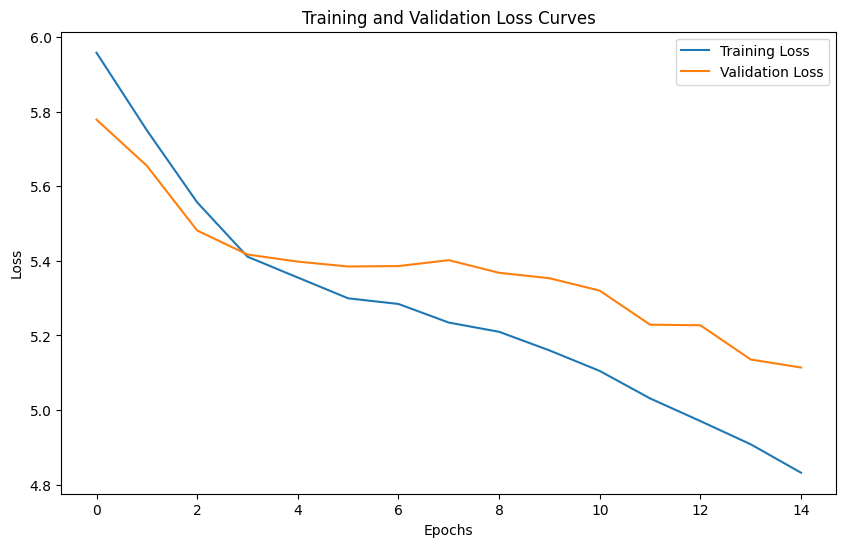

In [44]:
# Plot Training and Validation Loss Curves
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.show()

# Evaluation

Evaluate the model on the test set and display metrics.


In [ ]:
# Evaluate the model
test_dataset = ASLDataset(X_test, y_test, mask_test.sum(axis=1).astype(int))
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)
model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        inputs, targets, lengths = batch
        inputs, targets, lengths = inputs.to(device), targets.to(device), lengths.to(device)
        outputs = model(inputs, lengths)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
test_loss /= len(test_loader)
accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Save the model for transfer learning
os.makedirs('./models', exist_ok=True)  # Create directory if it doesn't exist
torch.save({
    'model_state_dict': model.state_dict(),
    'input_size': input_size,
    'hidden_size': best_hidden_size,
    'dropout_rate': best_dropout_rate,
    'output_size': output_size,
    'accuracy': accuracy
}, "./models/transfer_learning_model.pth")
print("Model saved for transfer learning!")

# Inference

Test the model on new data or perform real-time inference.


In [ ]:
# Example inference
model.eval()
sample = torch.tensor(X_test[0:1], dtype=torch.float32).to(device)
sample_length = torch.tensor([mask_test[0].sum()], dtype=torch.long).to(device)
with torch.no_grad():
    prediction = model(sample, sample_length)
    predicted_label = torch.argmax(prediction, dim=1).item()
print(f"Predicted label: {predicted_label}, True label: {y_test[0]}")